## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [162]:
%config IPCompleter.greedy=True

In [3]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [4]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [5]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [75]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [23]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [24]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [25]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [26]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [27]:
target = 'survived'

In [42]:
vars_num = [var 
            for var in data.columns
            if data[var].dtypes != 'O' and var != target]

vars_cat = [var
           for var in data.columns
           if data[var].dtypes == 'O' and var != target]

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4
10


### Find missing values in variables

In [43]:
def find_na(X, cols):
    
    return X[cols].isnull().mean()
    

# first in numerical variables
find_na(data, vars_num)


pclass    0.000000
age       0.200917
sibsp     0.000000
parch     0.000000
fare      0.000764
dtype: float64

In [44]:
# now in categorical variables
find_na(data, vars_cat)



sex         0.000000
cabin       0.774637
embarked    0.001528
title       0.000000
dtype: float64

### Determine cardinality of categorical variables

In [58]:
for var in vars_cat:
    print(f'{var} : {data[var].nunique()}')    

sex : 2
cabin : 181
embarked : 3
title : 5


### Determine the distribution of numerical variables

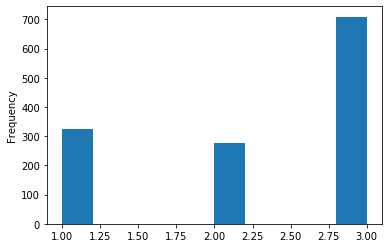

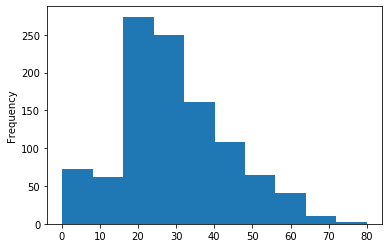

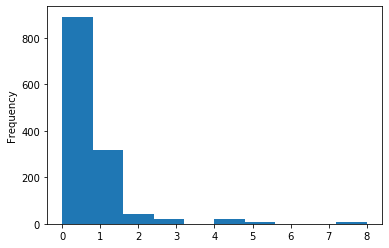

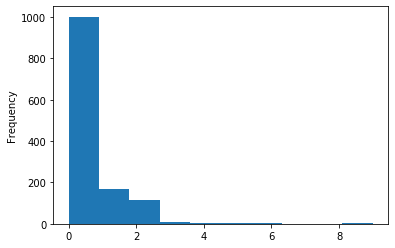

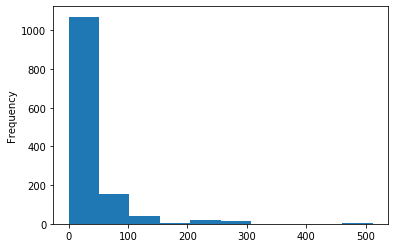

In [71]:
def print_distributions(X, col):

    X[col].plot(kind='hist')
    plt.show()
    
for col in vars_num:
    print_distributions(data, col)
    

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [273]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 15), (262, 15))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [274]:
def get_first_cabin(row):
    try:
        return row[0]
    except:
        return np.nan
    
X_train['cabin'] = X_train['cabin'].apply(get_first_cabin)
X_test['cabin'] = X_test['cabin'].apply(get_first_cabin)



### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [275]:
def get_mapper_median(X_train):
    
    mapper_median = X_train.agg('median').to_dict()
    joblib.dump(mapper_median, 'missing_numerical_mapper_median.pkl')
    
    return mapper_median


def impute_na_numerical(X, col, mapper_median):
    
    X = X.copy()
    col_median = X[col].median
    X[col+'_na'] = np.where(X[col].isnull(), 1, 0)
    X[col] = X[col].fillna(col_median)
    
    return pd.concat([X[col], X[col+'_na']], axis=1)




In [287]:
get_mapper_median(X_train[vars_num])
joblib.load('missing_numerical_mapper_median.pkl')
    

for col in vars_num:
    # train
    X_train.loc[:, [col, col+'_na']] = impute_na_numerical(X_train,
                                                           col,
                                                           joblib.load('missing_numerical_mapper_median.pkl'))

    # test
    X_test.loc[:, [col, col+'_na']] = impute_na_numerical(X_test,
                                                          col,
                                                          joblib.load('missing_numerical_mapper_median.pkl'))

    
print(X_train.isnull().mean())
print(X_test.isnull().mean())

print(X_train[[col+'_na' for col in vars_num]].mean())
# print(X_test.isnull().mean())


pclass       0.0
sex          0.0
age          0.0
sibsp        0.0
parch        0.0
fare         0.0
cabin        0.0
embarked     0.0
title        0.0
pclass_na    0.0
age_na       0.0
sibsp_na     0.0
parch_na     0.0
fare_na      0.0
title_na     0.0
dtype: float64
pclass       0.0
sex          0.0
age          0.0
sibsp        0.0
parch        0.0
fare         0.0
cabin        0.0
embarked     0.0
title        0.0
pclass_na    0.0
age_na       0.0
sibsp_na     0.0
parch_na     0.0
fare_na      0.0
title_na     0.0
dtype: float64
pclass_na    0.0
age_na       0.0
sibsp_na     0.0
parch_na     0.0
fare_na      0.0
dtype: float64


In [286]:
vars_num[]

IndexError: list index out of range

### Replace Missing data in categorical variables with the string **Missing**

In [212]:
def impute_na_cat(X, col, replacement='Missing'):
    return X[col].fillna(replacement)


for col in vars_cat:
    
    X_train[col] = impute_na_cat(X_train, col)
    X_test[col] = impute_na_cat(X_test, col)
    

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [220]:
def get_frequent_labels(X, col, th=0.05):
    
    labels = X[col].value_counts(normalize=True)
    frequent_labels = labels[labels > th].index.to_list()
    joblib.dump(frequent_labels, 'frequent_labels.pkl')
    
def replace_rare_labels(X, col, frequent_labels, rare_label='Rare'):

    return np.where(X[col].isin(frequent_labels), X[col], rare_label)
    
    
get_frequent_labels(X_train, 'sex', th=0.05)    

for col in vars_cat:
    X_train[col] = replace_rare_labels(X_train, col, joblib.load('frequent_labels.pkl'))
    X_test[col] = replace_rare_labels(X_test, col, joblib.load('frequent_labels.pkl'))
    

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [249]:
from sklearn.preprocessing import OneHotEncoder

def fit_OneHotEncoder(X, cols):

    encoder = OneHotEncoder(drop='first')
    encoder = encoder.fit(X[cols])
    joblib.dump(encoder, 'encoder.pkl')
    return encoder

def transform_OneHotEncoder(X, cols, encoder):
    
    return encoder.transform(X[cols]).to_array()






In [266]:
X_train[vars_cat]

,sex,cabin,embarked,title
1118,male,Rare,Rare,Rare
44,female,Rare,Rare,Rare
1072,male,Rare,Rare,Rare
1130,female,Rare,Rare,Rare
574,male,Rare,Rare,Rare
...,...,...,...,...
763,female,Rare,Rare,Rare
835,male,Rare,Rare,Rare
1216,female,Rare,Rare,Rare
559,female,Rare,Rare,Rare


In [272]:
X_train[vars_cat]
X_train['cabin'].unique()

array(['Rare'], dtype=object)

In [270]:
encoder = OneHotEncoder(drop='first')
encoder = encoder.fit(X_train[vars_cat])
encoder.categories_


# encoder.transform(X_train[vars_cat]).toarray().



[array(['female', 'male'], dtype=object),
 array(['Rare'], dtype=object),
 array(['Rare'], dtype=object),
 array(['Rare'], dtype=object)]

In [ ]:
ohe = OneHotEncoder(categories='auto')
feature_arr = ohe.fit_transform(df[['phone','city']]).toarray()
feature_labels = ohe.categories_
And then you just need to do the following:

feature_labels = np.array(feature_labels).ravel()
Which enables you to name your columns like you wanted:

features = pd.DataFrame(feature_arr, columns=feature_labels)

In [250]:
fit_OneHotEncoder(X_train, vars_cat)

OneHotEncoder(categories='auto', drop='first', dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [251]:
transform_OneHotEncoder(X_train, vars_cat, joblib.load('encoder.pkl'))

AttributeError: to_array not found

### Scale the variables

- Use the standard scaler from Scikit-learn

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**